In [1]:
# !pip install -r requirements.txt

In [2]:
# !python preprocess.py --data_root "./mvlrs_v1/main" --preprocessed_root "./lrs2_preprocessed" 

In [3]:
%cd ../input/wave2lip/wav2lip_homework

/kaggle/input/wave2lip/wav2lip_homework


In [4]:
import torch
from torch import nn
from torch.nn import functional as F

class Conv2d(nn.Module):
    def __init__(self, cin, cout, kernel_size, stride, padding, residual=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv_block = nn.Sequential(
                            nn.Conv2d(cin, cout, kernel_size, stride, padding),
                            nn.BatchNorm2d(cout)
                            )
        self.act = nn.ReLU()
        self.residual = residual

    def forward(self, x):
        out = self.conv_block(x)
        if self.residual:
            out += x
        return self.act(out)

In [5]:
import torch
from torch import nn
from torch.nn import functional as F

class SyncNet_color(nn.Module):
    def __init__(self):
        super(SyncNet_color, self).__init__()
        

        self.face_encoder = nn.Sequential(
            Conv2d(15, 32, kernel_size=(7, 7), stride=1, padding=3),

            Conv2d(32, 64, kernel_size=5, stride=(1, 2), padding=1),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            Conv2d(512, 512, kernel_size=3, stride=1, padding=0),
            Conv2d(512, 512, kernel_size=1, stride=1, padding=0),)

        self.audio_encoder = nn.Sequential(
            Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(32, 64, kernel_size=3, stride=(3, 1), padding=1),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(64, 128, kernel_size=3, stride=3, padding=1),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(128, 256, kernel_size=3, stride=(3, 2), padding=1),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(256, 512, kernel_size=3, stride=1, padding=0),
            Conv2d(512, 512, kernel_size=1, stride=1, padding=0),)

    def forward(self, audio_sequences, face_sequences): # audio_sequences := (B, dim, T)
        
        #########################TODO#######################
        # 正向传播
        face_embedding = self.face_encoder(face_sequences)
        audio_embedding = self.audio_encoder(audio_sequences)

        audio_embedding = audio_embedding.view(audio_embedding.size(0), -1)
        face_embedding = face_embedding.view(face_embedding.size(0), -1)

        audio_embedding = F.normalize(audio_embedding, p=2, dim=1)
        face_embedding = F.normalize(face_embedding, p=2, dim=1)


        return audio_embedding, face_embedding

In [6]:
from os.path import dirname, join, basename, isfile
from tqdm import tqdm

from models import SyncNet_color as SyncNet
import audio

import torch
from torch import nn
from torch import optim
import torch.backends.cudnn as cudnn
from torch.utils import data as data_utils
import numpy as np

from glob import glob

import os, random, cv2, argparse
from hparams import hparams, get_image_list

#### 2.数据集的定义

In [7]:
global_step = 0 
global_epoch = 0 
use_cuda = torch.cuda.is_available()
print('use_cuda: {}'.format(use_cuda))

syncnet_T = 5 
syncnet_mel_step_size = 16 
data_root="/kaggle/input/wav2lippreprocessed/lrs2_preprocessed" 

use_cuda: True


In [8]:
class Dataset(object):
    def __init__(self, split):
        self.all_videos = get_image_list(data_root, split)

    def get_frame_id(self, frame):
        return int(basename(frame).split('.')[0])

    def get_window(self, start_frame):
        start_id = self.get_frame_id(start_frame)
        vidname = dirname(start_frame)

        window_fnames = []
        for frame_id in range(start_id, start_id + syncnet_T):
            frame = join(vidname, '{}.jpg'.format(frame_id))
            if not isfile(frame):
                return None
            window_fnames.append(frame)
        return window_fnames

    def crop_audio_window(self, spec, start_frame):
        # num_frames = (T x hop_size * fps) / sample_rate
        start_frame_num = self.get_frame_id(start_frame)
        start_idx = int(80. * (start_frame_num / float(hparams.fps)))

        end_idx = start_idx + syncnet_mel_step_size

        return spec[start_idx : end_idx, :]


    def __len__(self):
        return len(self.all_videos)

    def __getitem__(self, idx):
        """
        return: x,mel,y
        x: 五张嘴唇图片
        mel：对应的语音的mel spectrogram
        t：同步or不同步
        
        """
        while 1:
            idx = random.randint(0, len(self.all_videos) - 1)
            vidname = self.all_videos[idx]

            img_names = list(glob(join(vidname, '*.jpg')))
            if len(img_names) <= 3 * syncnet_T:
                continue
            img_name = random.choice(img_names)
            wrong_img_name = random.choice(img_names)
            while wrong_img_name == img_name:
                wrong_img_name = random.choice(img_names)
            
            
            #随机决定是产生负样本还是正样本
            if random.choice([True, False]):
                y = torch.ones(1).float()
                chosen = img_name
            else:
                y = torch.zeros(1).float()
                chosen = wrong_img_name

            window_fnames = self.get_window(chosen)
            if window_fnames is None:
                continue

            window = []
            all_read = True
            for fname in window_fnames:
                img = cv2.imread(fname)
                if img is None:
                    all_read = False
                    break
                try:
                    img = cv2.resize(img, (hparams.img_size, hparams.img_size))
                except Exception as e:
                    all_read = False
                    break

                window.append(img)

            if not all_read: continue

            try:
                wavpath = join(vidname, "audio.wav")
                wav = audio.load_wav(wavpath, hparams.sample_rate)

                orig_mel = audio.melspectrogram(wav).T
            except Exception as e:
                continue

            mel = self.crop_audio_window(orig_mel.copy(), img_name)

            if (mel.shape[0] != syncnet_mel_step_size):
                continue

            # H x W x 3 * T
            x = np.concatenate(window, axis=2) / 255.
            x = x.transpose(2, 0, 1)
            x = x[:, x.shape[1]//2:]

            x = torch.FloatTensor(x)
            mel = torch.FloatTensor(mel.T).unsqueeze(0)

            return x, mel, y

In [9]:
ds=Dataset("train")
x,mel,t=ds[0]
print(x.shape)
print(mel.shape)
print(t.shape)

torch.Size([15, 48, 96])
torch.Size([1, 80, 16])
torch.Size([1])


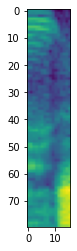

In [10]:
import matplotlib.pyplot as plt
plt.imshow(mel[0].numpy())

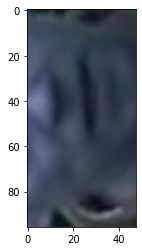

In [11]:
plt.imshow(x[:3,:,:].transpose(0,2).numpy())

In [12]:
logloss = nn.BCELoss() 
def cosine_loss(a, v, y):
    """
    a: audio_encoder的输出
    v: video face_encoder的输出
    y: 是否同步的真实值
    """
    d = nn.functional.cosine_similarity(a, v)
    loss = logloss(d.unsqueeze(1), y)

    return loss

In [13]:
def train(device, model, train_data_loader, test_data_loader, optimizer,
          checkpoint_dir=None, checkpoint_interval=None, nepochs=None):

    global global_step, global_epoch
    resumed_step = global_step
    
    while global_epoch < nepochs:
        running_loss = 0.
        prog_bar = tqdm(enumerate(train_data_loader))
        for step, (x, mel, y) in prog_bar:
            model.train()
            optimizer.zero_grad()

            x = x.to(device)

            mel = mel.to(device)

            a, v = model(mel, x)
            y = y.to(device)

            loss = cosine_loss(a, v, y)
            loss.backward()
            optimizer.step()
                
            

            global_step += 1
            cur_session_steps = global_step - resumed_step
            running_loss += loss.item()

            if global_step == 1 or global_step % checkpoint_interval == 0:
                save_checkpoint(
                    model, optimizer, global_step, checkpoint_dir, global_epoch)

            if global_step % hparams.syncnet_eval_interval == 0:
                with torch.no_grad():
                    eval_model(test_data_loader, global_step, device, model, checkpoint_dir)

            prog_bar.set_description('Epoch: {} Loss: {}'.format(global_epoch, running_loss / (step + 1)))

        global_epoch += 1

def eval_model(test_data_loader, global_step, device, model, checkpoint_dir):
    eval_steps = 1400
    print('Evaluating for {} steps'.format(eval_steps))
    losses = []
    while 1:
        for step, (x, mel, y) in enumerate(test_data_loader):

            model.eval()

            # Transform data to CUDA device
            x = x.to(device)

            mel = mel.to(device)

            a, v = model(mel, x)
            y = y.to(device)

            loss = cosine_loss(a, v, y)
            losses.append(loss.item())

            if step > eval_steps: break

        averaged_loss = sum(losses) / len(losses)
        print(averaged_loss)

        return

latest_checkpoint_path = ''
def save_checkpoint(model, optimizer, step, checkpoint_dir, epoch):
    global latest_checkpoint_path
    
    checkpoint_path = join(
        checkpoint_dir, "checkpoint_step{:09d}.pth".format(global_step))
    optimizer_state = optimizer.state_dict() if hparams.save_optimizer_state else None
    torch.save({
        "state_dict": model.state_dict(),
        "optimizer": optimizer_state,
        "global_step": step,
        "global_epoch": epoch,
    }, checkpoint_path)
    latest_checkpoint_path = checkpoint_path
    print("Saved checkpoint:", checkpoint_path)

def _load(checkpoint_path):
    if use_cuda:
        checkpoint = torch.load(checkpoint_path)
    else:
        checkpoint = torch.load(checkpoint_path,
                                map_location=lambda storage, loc: storage)
    return checkpoint

def load_checkpoint(path, model, optimizer, reset_optimizer=False):
    global global_step
    global global_epoch

    print("Load checkpoint from: {}".format(path))
    checkpoint = _load(path)
    model.load_state_dict(checkpoint["state_dict"])
    if not reset_optimizer:
        optimizer_state = checkpoint["optimizer"]
        if optimizer_state is not None:
            print("Load optimizer state from {}".format(path))
            optimizer.load_state_dict(checkpoint["optimizer"])
    global_step = checkpoint["global_step"]
    global_epoch = checkpoint["global_epoch"]

    return model

In [14]:
checkpoint_dir = "/kaggle/working/expert_checkpoints/"
checkpoint_path = '/kaggle/input/wav2lip24epoch/expert_checkpoints/checkpoint_step000060000.pth'


if not os.path.exists(checkpoint_dir): os.mkdir(checkpoint_dir)

# Dataset and Dataloader setup
train_dataset = Dataset('train')
test_dataset = Dataset('val')

train_data_loader = data_utils.DataLoader(
    train_dataset, batch_size=hparams.batch_size, shuffle=True,
    num_workers=hparams.num_workers)

test_data_loader = data_utils.DataLoader(
    test_dataset, batch_size=hparams.batch_size,
    num_workers=8)

device = torch.device("cuda" if use_cuda else "cpu")

# Model

model = SyncNet().to(device)
print('total trainable params {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad],
                       lr=1e-5)

if checkpoint_path is not None:
    load_checkpoint(checkpoint_path, model, optimizer, reset_optimizer=True)

train(device, model, train_data_loader, test_data_loader, optimizer,
      checkpoint_dir=checkpoint_dir,
      checkpoint_interval=hparams.syncnet_checkpoint_interval,
      nepochs=27)

total trainable params 16435072
Load checkpoint from: /kaggle/input/wav2lip24epoch/expert_checkpoints/checkpoint_step000060000.pth


Epoch: 20 Loss: 0.48332203482562125: : 2865it [20:44,  2.30it/s]
Epoch: 21 Loss: 0.4821069194332259: : 2865it [19:16,  2.48it/s]
Epoch: 22 Loss: 0.47878145759122326: : 2865it [19:23,  2.46it/s]
Epoch: 23 Loss: 0.47948348685632064: : 1404it [09:41,  2.60it/s]

Saved checkpoint: /kaggle/working/expert_checkpoints/checkpoint_step000070000.pth
Evaluating for 1400 steps


Epoch: 23 Loss: 0.4799394829313892: : 1407it [10:04,  3.92s/it]

0.4412049684016144


Epoch: 23 Loss: 0.4790076069130739: : 2865it [20:04,  2.38it/s]
Epoch: 24 Loss: 0.4703784715338735: : 2865it [19:39,  2.43it/s]
Epoch: 25 Loss: 0.4672579793561816: : 2865it [19:05,  2.50it/s]
Epoch: 26 Loss: 0.4646043508035426: : 2809it [18:40,  2.67it/s]

Saved checkpoint: /kaggle/working/expert_checkpoints/checkpoint_step000080000.pth
Evaluating for 1400 steps


Epoch: 26 Loss: 0.4646491017185976: : 2810it [19:00,  6.47s/it] 

0.432718401446062


Epoch: 26 Loss: 0.4643614772414662: : 2865it [19:12,  2.49it/s]


In [15]:
class nonorm_Conv2d(nn.Module): 
    def __init__(self, cin, cout, kernel_size, stride, padding, residual=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv_block = nn.Sequential(
                            nn.Conv2d(cin, cout, kernel_size, stride, padding),
                            )
        self.act = nn.LeakyReLU(0.01, inplace=True)

    def forward(self, x):
        out = self.conv_block(x)
        return self.act(out)

class Conv2dTranspose(nn.Module):
    def __init__(self, cin, cout, kernel_size, stride, padding, output_padding=0, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.conv_block = nn.Sequential(
                            nn.ConvTranspose2d(cin, cout, kernel_size, stride, padding, output_padding),
                            nn.BatchNorm2d(cout)
                            )
        self.act = nn.ReLU()

    def forward(self, x):
        out = self.conv_block(x)
        return self.act(out)

In [16]:


class Wav2Lip(nn.Module):
    def __init__(self):
        super(Wav2Lip, self).__init__()

        self.face_encoder_blocks = nn.ModuleList([
            nn.Sequential(Conv2d(6, 16, kernel_size=7, stride=1, padding=3)), # 96,96

            nn.Sequential(Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # 48,48
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True)),

            nn.Sequential(Conv2d(32, 64, kernel_size=3, stride=2, padding=1),    # 24,24
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True)),

            nn.Sequential(Conv2d(64, 128, kernel_size=3, stride=2, padding=1),   # 12,12
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True)),

            nn.Sequential(Conv2d(128, 256, kernel_size=3, stride=2, padding=1),       # 6,6
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True)),

            nn.Sequential(Conv2d(256, 512, kernel_size=3, stride=2, padding=1),     # 3,3
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1, residual=True),),
            
            nn.Sequential(Conv2d(512, 512, kernel_size=3, stride=1, padding=0),     # 1, 1
            Conv2d(512, 512, kernel_size=1, stride=1, padding=0)),])

        self.audio_encoder = nn.Sequential(
            Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(32, 64, kernel_size=3, stride=(3, 1), padding=1),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(64, 128, kernel_size=3, stride=3, padding=1),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(128, 256, kernel_size=3, stride=(3, 2), padding=1),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(256, 512, kernel_size=3, stride=1, padding=0),
            Conv2d(512, 512, kernel_size=1, stride=1, padding=0),)

        self.face_decoder_blocks = nn.ModuleList([
            nn.Sequential(Conv2d(512, 512, kernel_size=1, stride=1, padding=0),),

            nn.Sequential(Conv2dTranspose(1024, 512, kernel_size=3, stride=1, padding=0), # 3,3
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1, residual=True),),

            nn.Sequential(Conv2dTranspose(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1, residual=True),), # 6, 6

            nn.Sequential(Conv2dTranspose(768, 384, kernel_size=3, stride=2, padding=1, output_padding=1),
            Conv2d(384, 384, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(384, 384, kernel_size=3, stride=1, padding=1, residual=True),), # 12, 12

            nn.Sequential(Conv2dTranspose(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),), # 24, 24

            nn.Sequential(Conv2dTranspose(320, 128, kernel_size=3, stride=2, padding=1, output_padding=1), 
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),), # 48, 48

            nn.Sequential(Conv2dTranspose(160, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),),]) # 96,96

        self.output_block = nn.Sequential(Conv2d(80, 32, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(32, 3, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()) 

    def forward(self, audio_sequences, face_sequences):
        # audio_sequences = (B, T, 1, 80, 16)
        B = audio_sequences.size(0)

        input_dim_size = len(face_sequences.size())
        if input_dim_size > 4:
            audio_sequences = torch.cat([audio_sequences[:, i] for i in range(audio_sequences.size(1))], dim=0)
            face_sequences = torch.cat([face_sequences[:, :, i] for i in range(face_sequences.size(2))], dim=0)

        audio_embedding = self.audio_encoder(audio_sequences) # B, 512, 1, 1

        feats = []
        x = face_sequences
        for f in self.face_encoder_blocks:
            x = f(x)
            feats.append(x)

        x = audio_embedding
        for f in self.face_decoder_blocks:
            x = f(x)
            try:
                x = torch.cat((x, feats[-1]), dim=1)
            except Exception as e:
                print(x.size())
                print(feats[-1].size())
                raise e
            
            feats.pop()

        x = self.output_block(x)

        if input_dim_size > 4:
            x = torch.split(x, B, dim=0) # [(B, C, H, W)]
            outputs = torch.stack(x, dim=2) # (B, C, T, H, W)

        else:
            outputs = x
            
        return outputs

In [17]:

class Wav2Lip_disc_qual(nn.Module):
    def __init__(self):
        super(Wav2Lip_disc_qual, self).__init__()

        self.face_encoder_blocks = nn.ModuleList([
            nn.Sequential(nonorm_Conv2d(3, 32, kernel_size=7, stride=1, padding=3)), # 48,96

            nn.Sequential(nonorm_Conv2d(32, 64, kernel_size=5, stride=(1, 2), padding=2), # 48,48
            nonorm_Conv2d(64, 64, kernel_size=5, stride=1, padding=2)),

            nn.Sequential(nonorm_Conv2d(64, 128, kernel_size=5, stride=2, padding=2),    # 24,24
            nonorm_Conv2d(128, 128, kernel_size=5, stride=1, padding=2)),

            nn.Sequential(nonorm_Conv2d(128, 256, kernel_size=5, stride=2, padding=2),   # 12,12
            nonorm_Conv2d(256, 256, kernel_size=5, stride=1, padding=2)),

            nn.Sequential(nonorm_Conv2d(256, 512, kernel_size=3, stride=2, padding=1),       # 6,6
            nonorm_Conv2d(512, 512, kernel_size=3, stride=1, padding=1)),

            nn.Sequential(nonorm_Conv2d(512, 512, kernel_size=3, stride=2, padding=1),     # 3,3
            nonorm_Conv2d(512, 512, kernel_size=3, stride=1, padding=1),),
            
            nn.Sequential(nonorm_Conv2d(512, 512, kernel_size=3, stride=1, padding=0),     # 1, 1
            nonorm_Conv2d(512, 512, kernel_size=1, stride=1, padding=0)),])

        self.binary_pred = nn.Sequential(nn.Conv2d(512, 1, kernel_size=1, stride=1, padding=0), nn.Sigmoid())
        self.label_noise = .0

    def get_lower_half(self, face_sequences):
        return face_sequences[:, :, face_sequences.size(2)//2:]

    def to_2d(self, face_sequences):
        B = face_sequences.size(0)
        face_sequences = torch.cat([face_sequences[:, :, i] for i in range(face_sequences.size(2))], dim=0)
        return face_sequences

    def perceptual_forward(self, false_face_sequences):
        false_face_sequences = self.to_2d(false_face_sequences)
        false_face_sequences = self.get_lower_half(false_face_sequences)

        false_feats = false_face_sequences
        for f in self.face_encoder_blocks:
            false_feats = f(false_feats)

        false_pred_loss = F.binary_cross_entropy(self.binary_pred(false_feats).view(len(false_feats), -1), 
                                        torch.ones((len(false_feats), 1)).cuda())

        return false_pred_loss

    def forward(self, face_sequences):
        face_sequences = self.to_2d(face_sequences)
        face_sequences = self.get_lower_half(face_sequences)

        x = face_sequences
        for f in self.face_encoder_blocks:
            x = f(x)

        return self.binary_pred(x).view(len(x), -1)

In [18]:
global_step = 0
global_epoch = 0
use_cuda = torch.cuda.is_available()
print('use_cuda: {}'.format(use_cuda))

syncnet_T = 5
syncnet_mel_step_size = 16

class Dataset(object):
    def __init__(self, split):
        self.all_videos = get_image_list(data_root, split)

    def get_frame_id(self, frame):
        return int(basename(frame).split('.')[0])

    def get_window(self, start_frame):
        start_id = self.get_frame_id(start_frame)
        vidname = dirname(start_frame)

        window_fnames = []
        for frame_id in range(start_id, start_id + syncnet_T):
            frame = join(vidname, '{}.jpg'.format(frame_id))
            if not isfile(frame):
                return None
            window_fnames.append(frame)
        return window_fnames

    def read_window(self, window_fnames):
        if window_fnames is None: return None
        window = []
        for fname in window_fnames:
            img = cv2.imread(fname)
            if img is None:
                return None
            try:
                img = cv2.resize(img, (hparams.img_size, hparams.img_size))
            except Exception as e:
                return None

            window.append(img)

        return window

    def crop_audio_window(self, spec, start_frame):
        if type(start_frame) == int:
            start_frame_num = start_frame
        else:
            start_frame_num = self.get_frame_id(start_frame) # 0-indexing ---> 1-indexing
        start_idx = int(80. * (start_frame_num / float(hparams.fps)))
        
        end_idx = start_idx + syncnet_mel_step_size

        return spec[start_idx : end_idx, :]

    def get_segmented_mels(self, spec, start_frame):
        mels = []
        assert syncnet_T == 5
        start_frame_num = self.get_frame_id(start_frame) + 1 # 0-indexing ---> 1-indexing
        if start_frame_num - 2 < 0: return None
        for i in range(start_frame_num, start_frame_num + syncnet_T):
            m = self.crop_audio_window(spec, i - 2)
            if m.shape[0] != syncnet_mel_step_size:
                return None
            mels.append(m.T)

        mels = np.asarray(mels)

        return mels

    def prepare_window(self, window):
        # 3 x T x H x W
        x = np.asarray(window) / 255.
        x = np.transpose(x, (3, 0, 1, 2))

        return x

    def __len__(self):
        return len(self.all_videos)

    def __getitem__(self, idx):
        while 1:
            idx = random.randint(0, len(self.all_videos) - 1) 
            vidname = self.all_videos[idx]
            img_names = list(glob(join(vidname, '*.jpg')))
            if len(img_names) <= 3 * syncnet_T:
                continue
            
            img_name = random.choice(img_names)
            wrong_img_name = random.choice(img_names)
            while wrong_img_name == img_name:
                wrong_img_name = random.choice(img_names)

            window_fnames = self.get_window(img_name)
            wrong_window_fnames = self.get_window(wrong_img_name)
            if window_fnames is None or wrong_window_fnames is None:
                continue

            window = self.read_window(window_fnames)
            if window is None:
                continue

            wrong_window = self.read_window(wrong_window_fnames)
            if wrong_window is None:
                continue

            try:
                
                wavpath = join(vidname, "audio.wav")
                wav = audio.load_wav(wavpath, hparams.sample_rate)
                #spectrogram
                orig_mel = audio.melspectrogram(wav).T
            except Exception as e:
                continue
            # 分割 mel-spectrogram
            mel = self.crop_audio_window(orig_mel.copy(), img_name)
            
            if (mel.shape[0] != syncnet_mel_step_size):
                continue

            indiv_mels = self.get_segmented_mels(orig_mel.copy(), img_name)
            if indiv_mels is None: continue

            window = self.prepare_window(window)
            y = window.copy()
            window[:, :, window.shape[2]//2:] = 0.

            wrong_window = self.prepare_window(wrong_window)
            x = np.concatenate([window, wrong_window], axis=0)

            x = torch.FloatTensor(x)
            mel = torch.FloatTensor(mel.T).unsqueeze(0)
            indiv_mels = torch.FloatTensor(indiv_mels).unsqueeze(1)
            y = torch.FloatTensor(y)
            return x, indiv_mels, mel, y

use_cuda: True


In [19]:
ds=Dataset("train")
x, indiv_mels, mel, y=ds[0]
print(x.shape)
print(indiv_mels.shape)
print(mel.shape)
print(y.shape)

torch.Size([6, 5, 96, 96])
torch.Size([5, 1, 80, 16])
torch.Size([1, 80, 16])
torch.Size([3, 5, 96, 96])


#### 3. 训练

In [20]:
#bceloss
logloss = nn.BCELoss()
def cosine_loss(a, v, y):
    d = nn.functional.cosine_similarity(a, v)
    loss = logloss(d.unsqueeze(1), y)

    return loss

device = torch.device("cuda" if use_cuda else "cpu")
syncnet = SyncNet().to(device) #  
for p in syncnet.parameters():
    p.requires_grad = False

    
#####L1 loss    
recon_loss = nn.L1Loss()
def get_sync_loss(mel, g):
    g = g[:, :, :, g.size(3)//2:]
    g = torch.cat([g[:, :, i] for i in range(syncnet_T)], dim=1)
    # B, 3 * T, H//2, W
    a, v = syncnet(mel, g)
    y = torch.ones(g.size(0), 1).float().to(device)
    return cosine_loss(a, v, y)

def train(device, model, disc, train_data_loader, test_data_loader, optimizer, disc_optimizer,
          checkpoint_dir=None, checkpoint_interval=None, nepochs=None):
    global global_step, global_epoch
    resumed_step = global_step

    while global_epoch < nepochs:
        print('Starting Epoch: {}'.format(global_epoch))
        running_sync_loss, running_l1_loss, disc_loss, running_perceptual_loss = 0., 0., 0., 0.
        running_disc_real_loss, running_disc_fake_loss = 0., 0.
        prog_bar = tqdm(enumerate(train_data_loader))
        for step, (x, indiv_mels, mel, gt) in prog_bar:
            disc.train()
            model.train()

            x = x.to(device)
            mel = mel.to(device)
            indiv_mels = indiv_mels.to(device)
            gt = gt.to(device)

            ### Train generator now. Remove ALL grads. 
            
            optimizer.zero_grad()
            disc_optimizer.zero_grad()

            g = model(indiv_mels, x)

            if hparams.syncnet_wt > 0.:
                sync_loss = get_sync_loss(mel, g) 
            else:
                sync_loss = 0.

            if hparams.disc_wt > 0.:
                perceptual_loss = disc.perceptual_forward(g)
            else:
                perceptual_loss = 0.

            l1loss = recon_loss(g, gt)#l1 loss，
            
            
            loss = hparams.syncnet_wt * sync_loss + hparams.disc_wt * perceptual_loss + \
                                    (1. - hparams.syncnet_wt - hparams.disc_wt) * l1loss

            loss.backward()
            optimizer.step()

            ### Remove all gradients before Training disc
            
            disc_optimizer.zero_grad()

            pred = disc(gt)
            disc_real_loss = F.binary_cross_entropy(pred, torch.ones((len(pred), 1)).to(device))
            disc_real_loss.backward()

            pred = disc(g.detach())
            disc_fake_loss = F.binary_cross_entropy(pred, torch.zeros((len(pred), 1)).to(device))
            disc_fake_loss.backward()

            disc_optimizer.step()

            running_disc_real_loss += disc_real_loss.item()
            running_disc_fake_loss += disc_fake_loss.item()

            # Logs
            global_step += 1
            cur_session_steps = global_step - resumed_step

            running_l1_loss += l1loss.item()
            if hparams.syncnet_wt > 0.:
                running_sync_loss += sync_loss.item()
            else:
                running_sync_loss += 0.

            if hparams.disc_wt > 0.:
                running_perceptual_loss += perceptual_loss.item()
            else:
                running_perceptual_loss += 0.

            if global_step == 1 or global_step % checkpoint_interval == 0:
                save_checkpoint(
                    model, optimizer, global_step, checkpoint_dir, global_epoch)
                save_checkpoint(disc, disc_optimizer, global_step, checkpoint_dir, global_epoch, prefix='disc_')


            if global_step % hparams.eval_interval == 0:
                with torch.no_grad():
                    average_sync_loss = eval_model(test_data_loader, global_step, device, model, disc)

                    if average_sync_loss < .75:
                        hparams.set_hparam('syncnet_wt', 0.03)

            prog_bar.set_description('L1: {}, Sync: {}, Percep: {} | Fake: {}, Real: {}'.format(running_l1_loss / (step + 1),
                                                                                        running_sync_loss / (step + 1),
                                                                                        running_perceptual_loss / (step + 1),
                                                                                        running_disc_fake_loss / (step + 1),
                                                                                        running_disc_real_loss / (step + 1)))

        global_epoch += 1

def eval_model(test_data_loader, global_step, device, model, disc):
    eval_steps = 300
    print('Evaluating for {} steps'.format(eval_steps))
    running_sync_loss, running_l1_loss, running_disc_real_loss, running_disc_fake_loss, running_perceptual_loss = [], [], [], [], []
    while 1:
        for step, (x, indiv_mels, mel, gt) in enumerate((test_data_loader)):
            model.eval()
            disc.eval()

            x = x.to(device)
            mel = mel.to(device)
            indiv_mels = indiv_mels.to(device)
            gt = gt.to(device)

            pred = disc(gt)
            disc_real_loss = F.binary_cross_entropy(pred, torch.ones((len(pred), 1)).to(device))

            g = model(indiv_mels, x)
            pred = disc(g)
            disc_fake_loss = F.binary_cross_entropy(pred, torch.zeros((len(pred), 1)).to(device))

            running_disc_real_loss.append(disc_real_loss.item())
            running_disc_fake_loss.append(disc_fake_loss.item())

            sync_loss = get_sync_loss(mel, g)
            
            if hparams.disc_wt > 0.:
                perceptual_loss = disc.perceptual_forward(g)
            else:
                perceptual_loss = 0.

            l1loss = recon_loss(g, gt)

            loss = hparams.syncnet_wt * sync_loss + hparams.disc_wt * perceptual_loss + \
                                    (1. - hparams.syncnet_wt - hparams.disc_wt) * l1loss

            running_l1_loss.append(l1loss.item())
            running_sync_loss.append(sync_loss.item())
            
            if hparams.disc_wt > 0.:
                running_perceptual_loss.append(perceptual_loss.item())
            else:
                running_perceptual_loss.append(0.)

            if step > eval_steps: break

        print('L1: {}, Sync: {}, Percep: {} | Fake: {}, Real: {}'.format(sum(running_l1_loss) / len(running_l1_loss),
                                                            sum(running_sync_loss) / len(running_sync_loss),
                                                            sum(running_perceptual_loss) / len(running_perceptual_loss),
                                                            sum(running_disc_fake_loss) / len(running_disc_fake_loss),
                                                             sum(running_disc_real_loss) / len(running_disc_real_loss)))
        return sum(running_sync_loss) / len(running_sync_loss)

latest_wav2lip_checkpoint = ''
def save_checkpoint(model, optimizer, step, checkpoint_dir, epoch, prefix=''):
    global latest_wav2lip_checkpoint
    checkpoint_path = join(
        checkpoint_dir, "{}checkpoint_step{:09d}.pth".format(prefix, global_step))
    if 'disc' not in checkpoint_path:
        latest_wav2lip_checkpoint = checkpoint_path
    optimizer_state = optimizer.state_dict() if hparams.save_optimizer_state else None
    torch.save({
        "state_dict": model.state_dict(),
        "optimizer": optimizer_state,
        "global_step": step,
        "global_epoch": epoch,
    }, checkpoint_path)
    print("Saved checkpoint:", checkpoint_path)

def _load(checkpoint_path):
    if use_cuda:
        checkpoint = torch.load(checkpoint_path)
    else:
        checkpoint = torch.load(checkpoint_path,
                                map_location=lambda storage, loc: storage)
    return checkpoint


def load_checkpoint(path, model, optimizer, reset_optimizer=False, overwrite_global_states=True):
    global global_step
    global global_epoch

    print("Load checkpoint from: {}".format(path))
    checkpoint = _load(path)
    s = checkpoint["state_dict"]
    new_s = {}
    for k, v in s.items():
        new_s[k.replace('module.', '')] = v
    model.load_state_dict(new_s)
    if not reset_optimizer:
        optimizer_state = checkpoint["optimizer"]
        if optimizer_state is not None:
            print("Load optimizer state from {}".format(path))
            optimizer.load_state_dict(checkpoint["optimizer"])
    if overwrite_global_states:
        global_step = checkpoint["global_step"]
        global_epoch = checkpoint["global_epoch"]

    return model

In [21]:
checkpoint_dir = "/kaggle/working/wav2lip_checkpoints"  #checkpoint 存储的位置

# Dataset and Dataloader setup
train_dataset = Dataset('train')
test_dataset = Dataset('val')

train_data_loader = data_utils.DataLoader(
    train_dataset, batch_size=hparams.batch_size, shuffle=True,
    num_workers=hparams.num_workers)

test_data_loader = data_utils.DataLoader(
    test_dataset, batch_size=hparams.batch_size,
    num_workers=4)
device = torch.device("cuda" if use_cuda else "cpu")

 # Model
model = Wav2Lip().to(device)
disc = Wav2Lip_disc_qual().to(device) 

print('total trainable params {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))
print('total DISC trainable params {}'.format(sum(p.numel() for p in disc.parameters() if p.requires_grad)))

optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad],
                       lr=hparams.initial_learning_rate,
                       betas=(0.5, 0.999))#####adam，betas=[0.5,0.999]
disc_optimizer = optim.Adam([p for p in disc.parameters() if p.requires_grad],
                            lr=hparams.disc_initial_learning_rate,
                            betas=(0.5, 0.999))#####adam，betas=[0.5,0.999]


# checkpoint_path=""
# load_checkpoint(checkpoint_path, model, optimizer, reset_optimizer=False)
# disc_checkpoint_path=""
# load_checkpoint(disc_checkpoint_path, disc, disc_optimizer, 
#                             reset_optimizer=False, overwrite_global_states=False)

syncnet_checkpoint_path = latest_checkpoint_path
# syncnet_checkpoint_path="/kaggle/working/expert_checkpoints/checkpoint_step000000001.pth"
load_checkpoint(syncnet_checkpoint_path, syncnet, None, reset_optimizer=True,
                            overwrite_global_states=False)

if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

# Train!
train(device, model, disc, train_data_loader, test_data_loader, optimizer, disc_optimizer,
          checkpoint_dir=checkpoint_dir,
          checkpoint_interval=hparams.checkpoint_interval,
          nepochs=5)

total trainable params 36298035
total DISC trainable params 14113793
Load checkpoint from: /kaggle/working/expert_checkpoints/checkpoint_step000080000.pth
Starting Epoch: 0


0it [00:00, ?it/s]

Saved checkpoint: /kaggle/working/wav2lip_checkpoints/checkpoint_step000000001.pth


L1: 0.2125028520822525, Sync: 0.0, Percep: 0.7112582325935364 | Fake: 0.6753584742546082, Real: 0.711258053779602: : 1it [00:14, 14.75s/it]

Saved checkpoint: /kaggle/working/wav2lip_checkpoints/disc_checkpoint_step000000001.pth


L1: 0.05340288229884797, Sync: 0.0, Percep: 0.7204441924746852 | Fake: 0.6801793053044074, Real: 0.6945417820647964: : 2865it [59:20,  1.24s/it]

Starting Epoch: 1



L1: 0.0413928986457524, Sync: 0.0, Percep: 0.7049959270811793 | Fake: 0.6840310145669909, Real: 0.6998657940038994: : 134it [02:59,  1.24s/it]

Saved checkpoint: /kaggle/working/wav2lip_checkpoints/checkpoint_step000003000.pth
Saved checkpoint: /kaggle/working/wav2lip_checkpoints/disc_checkpoint_step000003000.pth
Evaluating for 300 steps


L1: 0.04138963855803013, Sync: 0.0, Percep: 0.7048521986714116 | Fake: 0.6841630224828367, Real: 0.6996343100512469: : 135it [03:43, 14.20s/it]

L1: 0.03474966962547863, Sync: 1.433393979773802, Percep: 0.6570781057371813 | Fake: 0.7350428858224083, Real: 0.6459384718362022


L1: 0.039079156693519725, Sync: 0.0, Percep: 0.6948325128299404 | Fake: 0.6939024634178188, Real: 0.6914276647422118: : 2865it [59:55,  1.25s/it]


Starting Epoch: 2


L1: 0.03721257846206981, Sync: 0.0, Percep: 0.6973714775312345 | Fake: 0.6904829089083193, Real: 0.6949389966890271: : 269it [05:50,  1.25s/it]

Saved checkpoint: /kaggle/working/wav2lip_checkpoints/checkpoint_step000006000.pth
Saved checkpoint: /kaggle/working/wav2lip_checkpoints/disc_checkpoint_step000006000.pth
Evaluating for 300 steps


L1: 0.03723369523606918, Sync: 0.0, Percep: 0.6972903196458463 | Fake: 0.6905608594417572, Real: 0.6948745882069624: : 270it [06:36, 14.79s/it]

L1: 0.033142985995201504, Sync: 0.9321227468111936, Percep: 0.6870262044317582 | Fake: 0.699770409394713, Real: 0.6851317908834008


L1: 0.03566748835926593, Sync: 0.0, Percep: 0.6969164271837338 | Fake: 0.6923279718526787, Real: 0.6925369480933611: : 2865it [1:00:45,  1.27s/it]

Starting Epoch: 3



L1: 0.03445471352021588, Sync: 0.0, Percep: 0.6955329941050841 | Fake: 0.6938766646798294, Real: 0.6892058345129585: : 404it [08:38,  1.25s/it]

Saved checkpoint: /kaggle/working/wav2lip_checkpoints/checkpoint_step000009000.pth
Saved checkpoint: /kaggle/working/wav2lip_checkpoints/disc_checkpoint_step000009000.pth
Evaluating for 300 steps


L1: 0.03447484033711162, Sync: 0.0, Percep: 0.6955338844546566 | Fake: 0.6938694169491897, Real: 0.6891788571337123: : 405it [09:25, 15.03s/it]

L1: 0.03377383752890369, Sync: 0.8116050901658395, Percep: 0.6949812717297498 | Fake: 0.6921895707354826, Real: 0.6778730522183811


L1: 0.03413254674231507, Sync: 0.0, Percep: 0.6988335271156271 | Fake: 0.6907379700355297, Real: 0.6931049331788617: : 2865it [1:00:37,  1.27s/it]

Starting Epoch: 4



L1: 0.032855503223076156, Sync: 0.0, Percep: 0.6984667263800669 | Fake: 0.6912781460165757, Real: 0.6921107965851537: : 539it [11:22,  1.24s/it]

Saved checkpoint: /kaggle/working/wav2lip_checkpoints/checkpoint_step000012000.pth
Saved checkpoint: /kaggle/working/wav2lip_checkpoints/disc_checkpoint_step000012000.pth
Evaluating for 300 steps


L1: 0.03286198592503314, Sync: 0.0, Percep: 0.6985279241093882 | Fake: 0.6912137924521058, Real: 0.6921684326948943: : 540it [12:07, 14.45s/it]

L1: 0.027995452723082376, Sync: 0.706808291375637, Percep: 0.7177062884849661 | Fake: 0.670196591054692, Real: 0.7052458568530924


L1: 0.03382600274450596, Sync: 0.15704056348320078, Percep: 0.7008238289862819 | Fake: 0.6898790033075822, Real: 0.693933175199943: : 2865it [1:01:07,  1.28s/it]


In [22]:
# !python wav2lip_train.py --data_root lrs2_preprocessed/ --checkpoint_dir <folder_to_save_checkpoints> --syncnet_checkpoint_path <path_to_expert_disc_checkpoint>

In [23]:
from os import listdir, path
import numpy as np
import scipy, cv2, os, sys, argparse, audio
import json, subprocess, random, string
from tqdm import tqdm
from glob import glob
import torch, face_detection
from models import Wav2Lip
import platform
import audio

In [24]:
checkpoint_path="/kaggle/working/wav2lip_checkpoints/checkpoint_step000000001.pth"#生成器的checkpoint位置
checkpoint_path = latest_wav2lip_checkpoint
face="/kaggle/input/jakeydata/jakedrive.mp4" 
speech="/kaggle/input/jakeydata/laucky 2.wav"
resize_factor=1 
crop=[0,-1,0,-1] 
fps=25
static=False

In [25]:
if not os.path.isfile(face):
    raise ValueError('--face argument must be a valid path to video/image file')


else:# 若输入的是视频格式
    video_stream = cv2.VideoCapture(face)# 读取视频
    fps = video_stream.get(cv2.CAP_PROP_FPS)# 读取 fps

    print('Reading video frames...')

    full_frames = []
    #提取所有的帧
    while 1:
        still_reading, frame = video_stream.read()
        if not still_reading:
            video_stream.release()
            break
        if resize_factor > 1: # 进行下采样，降低分辨率
            frame = cv2.resize(frame, (frame.shape[1]//resize_factor, frame.shape[0]//resize_factor))

        

        y1, y2, x1, x2 =crop  # 裁剪
        if x2 == -1: x2 = frame.shape[1]
        if y2 == -1: y2 = frame.shape[0]

        frame = frame[y1:y2, x1:x2]

        full_frames.append(frame)

print ("Number of frames available for inference: "+str(len(full_frames)))

Reading video frames...
Number of frames available for inference: 169


In [26]:
#检查输入的音频是否为 .wav格式的，若不是则进行转换
if not speech.endswith('.wav'):
    print('Extracting raw audio...')
    command = 'ffmpeg -y -i {} -strict -2 {}'.format(speech, 'temp/temp.wav')

    subprocess.call(command, shell=True)
    speech = 'temp/temp.wav'

wav = audio.load_wav(speech, 16000)#保证采样率为16000
mel = audio.melspectrogram(wav)
print(mel.shape)


(80, 493)


In [27]:
wav2lip_batch_size=128 
mel_step_size=16

mel_chunks = []
mel_idx_multiplier = 80./fps 
i = 0
while 1:
    start_idx = int(i * mel_idx_multiplier)
    if start_idx + mel_step_size > len(mel[0]):
        mel_chunks.append(mel[:, len(mel[0]) - mel_step_size:])
        break
    mel_chunks.append(mel[:, start_idx : start_idx + mel_step_size])
    i += 1

print("Length of mel chunks: {}".format(len(mel_chunks)))

full_frames = full_frames[:len(mel_chunks)]

batch_size = wav2lip_batch_size

Length of mel chunks: 151


In [28]:
img_size = 96 
pads=[0,20,0,0] 
nosmooth=False
face_det_batch_size=16

def get_smoothened_boxes(boxes, T):
    for i in range(len(boxes)):
        if i + T > len(boxes):
            window = boxes[len(boxes) - T:]
        else:
            window = boxes[i : i + T]
        boxes[i] = np.mean(window, axis=0)
    return boxes

#人脸检测函数
def face_detect(images):
    detector = face_detection.FaceAlignment(face_detection.LandmarksType._2D, 
                                            flip_input=False, device=device)

    batch_size = face_det_batch_size

    while 1:
        predictions = []
        try:
            for i in tqdm(range(0, len(images), batch_size)):
                predictions.extend(detector.get_detections_for_batch(np.array(images[i:i + batch_size])))
        except RuntimeError:
            if batch_size == 1: 
                raise RuntimeError('Image too big to run face detection on GPU. Please use the --resize_factor argument')
            batch_size //= 2
            print('Recovering from OOM error; New batch size: {}'.format(batch_size))
            continue
        break

    results = []
    pady1, pady2, padx1, padx2 = pads
    for rect, image in zip(predictions, images):
        if rect is None:
            cv2.imwrite('temp/faulty_frame.jpg', image) # check this frame where the face was not detected.
            raise ValueError('Face not detected! Ensure the video contains a face in all the frames.')

        y1 = max(0, rect[1] - pady1)
        y2 = min(image.shape[0], rect[3] + pady2)
        x1 = max(0, rect[0] - padx1)
        x2 = min(image.shape[1], rect[2] + padx2)

        results.append([x1, y1, x2, y2])

    boxes = np.array(results)
    if not nosmooth: boxes = get_smoothened_boxes(boxes, T=5)
    results = [[image[y1: y2, x1:x2], (y1, y2, x1, x2)] for image, (x1, y1, x2, y2) in zip(images, boxes)]

    del detector
    return results 

box=[-1,-1,-1,-1]

def datagen(frames, mels):
    img_batch, mel_batch, frame_batch, coords_batch = [], [], [], []

    if box[0] == -1:# 如果未指定 特定的人脸边界的话
        if not static:# 是否使用视频的第一帧作为参考
            face_det_results = face_detect(frames) # BGR2RGB for CNN face detection
        else:
            face_det_results = face_detect([frames[0]])
    else:
        print('Using the specified bounding box instead of face detection...')
        y1, y2, x1, x2 = box
        face_det_results = [[f[y1: y2, x1:x2], (y1, y2, x1, x2)] for f in frames] # 裁剪出人脸结果

    for i, m in enumerate(mels):
        idx = 0 if static else i%len(frames)
        frame_to_save = frames[idx].copy()
        face, coords = face_det_results[idx].copy()

        face = cv2.resize(face, (img_size, img_size)) # 重采样到指定大小

        img_batch.append(face)
        mel_batch.append(m)
        frame_batch.append(frame_to_save)
        coords_batch.append(coords)

        if len(img_batch) >= wav2lip_batch_size:
            img_batch, mel_batch = np.asarray(img_batch), np.asarray(mel_batch)

            img_masked = img_batch.copy()
            img_masked[:, img_size//2:] = 0

            img_batch = np.concatenate((img_masked, img_batch), axis=3) / 255.
            mel_batch = np.reshape(mel_batch, [len(mel_batch), mel_batch.shape[1], mel_batch.shape[2], 1])

            yield img_batch, mel_batch, frame_batch, coords_batch
            img_batch, mel_batch, frame_batch, coords_batch = [], [], [], []

    if len(img_batch) > 0:
        img_batch, mel_batch = np.asarray(img_batch), np.asarray(mel_batch)

        img_masked = img_batch.copy()
        img_masked[:, img_size//2:] = 0

        img_batch = np.concatenate((img_masked, img_batch), axis=3) / 255.
        mel_batch = np.reshape(mel_batch, [len(mel_batch), mel_batch.shape[1], mel_batch.shape[2], 1])

        yield img_batch, mel_batch, frame_batch, coords_batch

mel_step_size = 16 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} for inference.'.format(device))


def _load(checkpoint_path):
    if device == 'cuda':
        checkpoint = torch.load(checkpoint_path)
    else:
        checkpoint = torch.load(checkpoint_path,
                                map_location=lambda storage, loc: storage)
    return checkpoint

def load_model(path):
    model = Wav2Lip()
    print("Load checkpoint from: {}".format(path))
    checkpoint = _load(path)
    s = checkpoint["state_dict"]
    new_s = {}
    for k, v in s.items():
        new_s[k.replace('module.', '')] = v
    model.load_state_dict(new_s)

    model = model.to(device)
    return model.eval()

Using cuda for inference.


In [29]:
os.mkdir('/kaggle/working/temp/')

In [30]:
full_frames = full_frames[:len(mel_chunks)]

batch_size = wav2lip_batch_size
gen = datagen(full_frames.copy(), mel_chunks)  

for i, (img_batch, mel_batch, frames, coords) in enumerate(tqdm(gen, 
                                        total=int(np.ceil(float(len(mel_chunks))/batch_size)))):
    
    if i == 0:
        model = load_model(checkpoint_path)
        print ("Model loaded")

        frame_h, frame_w = full_frames[0].shape[:-1]
        
        out = cv2.VideoWriter('/kaggle/working/temp/result_without_audio.mp4',
                                cv2.VideoWriter_fourcc(*'DIVX'), fps, (frame_w, frame_h))

    img_batch = torch.FloatTensor(np.transpose(img_batch, (0, 3, 1, 2))).to(device)
    mel_batch = torch.FloatTensor(np.transpose(mel_batch, (0, 3, 1, 2))).to(device)
    
    
    # img_batch,
    ##############TODO
    with torch.no_grad():
        pred = model(mel_batch, img_batch)
    
    pred = pred.cpu().numpy().transpose(0, 2, 3, 1) * 255.

    for p, f, c in zip(pred, frames, coords):
        y1, y2, x1, x2 = c
        p = cv2.resize(p.astype(np.uint8), (x2 - x1, y2 - y1))

        f[y1:y2, x1:x2] = p
        out.write(f)

out.release()


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Load checkpoint from: /kaggle/working/wav2lip_checkpoints/checkpoint_step000012000.pth
Model loaded


100%|██████████| 2/2 [00:06<00:00,  3.46s/it]


In [31]:
os.mkdir('/kaggle/working/result/')

In [32]:
outfile="/kaggle/working/result/result.mp4"
command = 'ffmpeg -y -i {} -i {} -strict -2 -q:v 1 {}'.format(speech, '/kaggle/working/temp/result_without_audio.mp4',outfile)
subprocess.call(command, shell=platform.system() != 'Windows')

1